In [1]:
import numpy as np

# 目标函数
def f(x):
    return x**2

# 均匀采样
N = 10000
samples_uniform = np.random.uniform(0, 1, N)
weights_uniform = np.ones(N) / N  # 权重都一样
estimate_uniform = np.sum(f(samples_uniform) * weights_uniform)

# 非均匀采样，采样密度 p(x) = 2*(1 - x)
# 反函数采样法：从均匀分布u~U[0,1]，x=1 - sqrt(1 - u)
u = np.random.uniform(0, 1, N)
samples_nonuniform = 1 - np.sqrt(1 - u)

# 采样概率密度 p(x)
def p(x):
    return 2 * (1 - x)

# 权重计算 w_i = f(x_i) / p(x_i)
weights_nonuniform = 1.0 / N * 1.0 / p(samples_nonuniform)  # 这里乘以 1/N 是因为采样点数量的归一化
estimate_nonuniform = np.sum(f(samples_nonuniform) * weights_nonuniform)

print(f"均匀采样估计积分：{estimate_uniform:.5f}")
print(f"非均匀采样估计积分：{estimate_nonuniform:.5f}")
print(f"理论积分值：{1/3:.5f}")

# 显示权重示例（前10个）
print("\n非均匀采样前10个点及其权重：")
for i in range(10):
    print(f"x={samples_nonuniform[i]:.4f}, weight={weights_nonuniform[i]:.5f}")


均匀采样估计积分：0.33168
非均匀采样估计积分：0.31129
理论积分值：0.33333

非均匀采样前10个点及其权重：
x=0.0495, weight=0.00005
x=0.1657, weight=0.00006
x=0.2438, weight=0.00007
x=0.2998, weight=0.00007
x=0.2716, weight=0.00007
x=0.5251, weight=0.00011
x=0.2955, weight=0.00007
x=0.0979, weight=0.00006
x=0.3528, weight=0.00008
x=0.2155, weight=0.00006


使用设备: cuda
GPU设备名称: NVIDIA GeForce RTX 2050
GPU内存: 3.8 GB
PyTorch CPU vs GPU 性能对比测试
Python版本: 2.5.1
设备: cuda

矩阵乘法性能对比测试
矩阵大小       CPU循环(s)     CPU张量(s)     GPU张量(s)     张量加速比        GPU加速比      
--------------------------------------------------------------------------------
64         0.1915       0.0001  0.0002       2427.2x      0.5x        
128        1.8048       0.0001  0.0001       16747.8x     1.4x        
256        15.0092      0.0005  0.0000       29892.3x     10.5x       
512        82.8619      0.0008  0.0001       104025.2x    5.4x        
1024       N/A          0.0050  0.0008       N/A          6.2x        
2048       N/A          0.0467  0.0060       N/A          7.7x        
4096       N/A          0.8130  0.0634       N/A          12.8x       

元素级运算性能对比测试
测试Python纯循环...
测试NumPy向量化...
测试PyTorch CPU...
测试PyTorch GPU...

向量大小: 10,000,000 元素
Python循环:    7.6378s
NumPy向量化:   0.0328s  (加速比: 233.1x)
PyTorch CPU:   0.0221s  (加速比: 345.5x)
PyTorch GPU:   0.0036s  (加速比: 2111

/tmp/ipykernel_27566/1929763405.py:302: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_27566/1929763405.py:302: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_27566/1929763405.py:302: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_27566/1929763405.py:302: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_27566/1929763405.py:302: UserWarning: Glyph 25191 (\N{CJK UNIFIED IDEOGRAPH-6267}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_27566/1929763405.py:302: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_27566/1929763405.py:302: UserWarning: Glyph 26102 (\N{CJK UNIFIED I

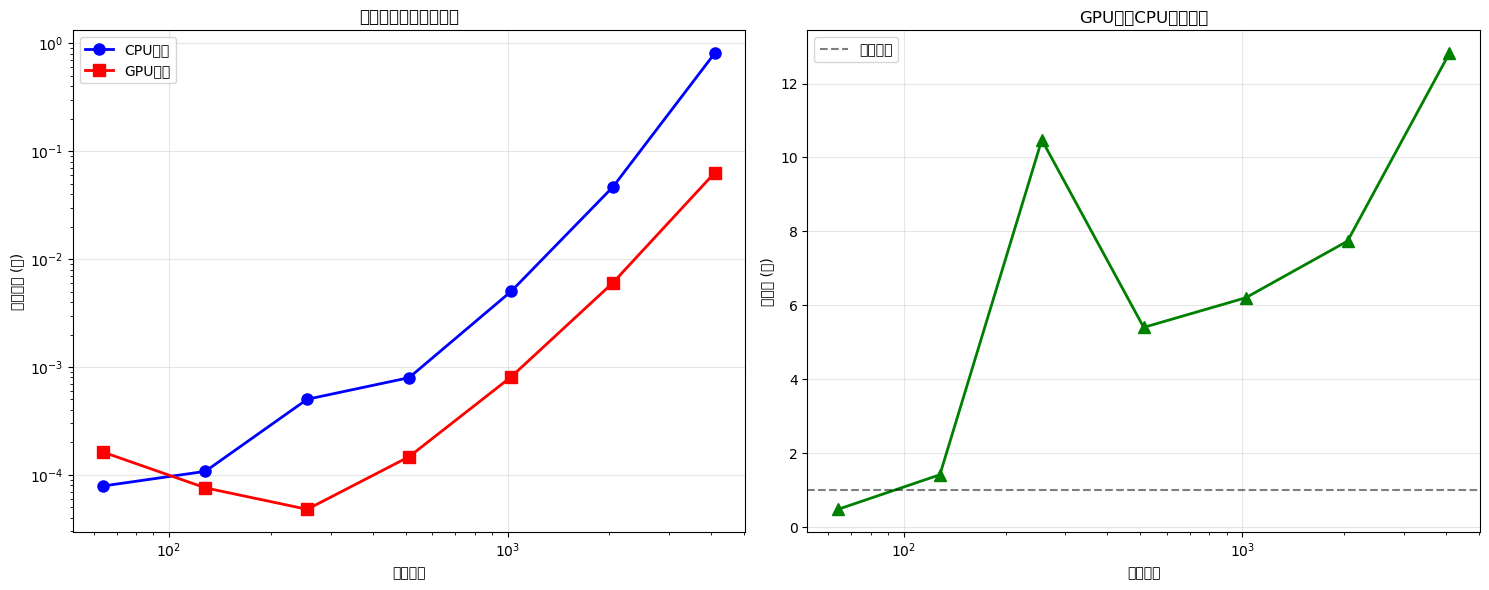


测试总结:
1. 纯Python循环是最慢的计算方式
2. PyTorch张量操作比纯循环快数十倍到数百倍
3. GPU在大规模并行计算中显著优于CPU
4. 对于小规模计算，CPU和GPU差异不大（GPU初始化开销）
5. 深度学习等大规模矩阵运算是GPU的强项


In [2]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# 检查CUDA是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
if torch.cuda.is_available():
    print(f"GPU设备名称: {torch.cuda.get_device_name(0)}")
    print(f"GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

def cpu_matrix_multiply_loop(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """使用纯Python for循环进行矩阵乘法（CPU）"""
    rows_a, cols_a = a.shape
    rows_b, cols_b = b.shape
    
    if cols_a != rows_b:
        raise ValueError("矩阵维度不匹配")
    
    # 初始化结果矩阵
    result = np.zeros((rows_a, cols_b))
    
    # 三重循环计算矩阵乘法
    for i in range(rows_a):
        for j in range(cols_b):
            for k in range(cols_a):
                result[i][j] += a[i][k] * b[k][j]
    
    return result

def benchmark_matrix_operations(sizes: List[int]) -> dict:
    """对比不同矩阵大小下的CPU vs GPU性能"""
    results = {
        'sizes': sizes,
        'cpu_loop_times': [],
        'cpu_tensor_times': [],
        'gpu_tensor_times': [],
        'speedup_vs_loop': [],
        'speedup_cpu_vs_gpu': []
    }
    
    print("=" * 80)
    print("矩阵乘法性能对比测试")
    print("=" * 80)
    print(f"{'矩阵大小':<10} {'CPU循环(s)':<12} {'CPU张量(s)':<12} {'GPU张量(s)':<12} {'张量加速比':<12} {'GPU加速比':<12}")
    print("-" * 80)
    
    for size in sizes:
        # 生成随机矩阵
        np.random.seed(42)  # 确保结果可重现
        a_np = np.random.randn(size, size).astype(np.float32)
        b_np = np.random.randn(size, size).astype(np.float32)
        
        # 1. CPU纯循环计算（只对小矩阵测试，避免时间过长）
        if size <= 512:
            start_time = time.time()
            _ = cpu_matrix_multiply_loop(a_np, b_np)
            cpu_loop_time = time.time() - start_time
        else:
            cpu_loop_time = None
        
        # 2. CPU张量计算
        a_cpu = torch.from_numpy(a_np)
        b_cpu = torch.from_numpy(b_np)
        
        # 预热
        _ = torch.mm(a_cpu, b_cpu)
        
        start_time = time.time()
        result_cpu = torch.mm(a_cpu, b_cpu)
        cpu_tensor_time = time.time() - start_time
        
        # 3. GPU张量计算（如果CUDA可用）
        if torch.cuda.is_available():
            a_gpu = a_cpu.to(device)
            b_gpu = b_cpu.to(device)
            
            # 预热GPU
            _ = torch.mm(a_gpu, b_gpu)
            torch.cuda.synchronize()  # 确保GPU操作完成
            
            start_time = time.time()
            result_gpu = torch.mm(a_gpu, b_gpu)
            torch.cuda.synchronize()  # 确保GPU操作完成
            gpu_tensor_time = time.time() - start_time
        else:
            gpu_tensor_time = None
        
        # 计算加速比
        if cpu_loop_time is not None:
            speedup_vs_loop = cpu_loop_time / cpu_tensor_time
        else:
            speedup_vs_loop = None
            
        if gpu_tensor_time is not None:
            speedup_cpu_vs_gpu = cpu_tensor_time / gpu_tensor_time
        else:
            speedup_cpu_vs_gpu = None
        
        # 记录结果
        results['cpu_loop_times'].append(cpu_loop_time)
        results['cpu_tensor_times'].append(cpu_tensor_time)
        results['gpu_tensor_times'].append(gpu_tensor_time)
        results['speedup_vs_loop'].append(speedup_vs_loop)
        results['speedup_cpu_vs_gpu'].append(speedup_cpu_vs_gpu)
        
        # 打印结果
        cpu_loop_str = f"{cpu_loop_time:.4f}" if cpu_loop_time else "N/A"
        gpu_tensor_str = f"{gpu_tensor_time:.4f}" if gpu_tensor_time else "N/A"
        speedup_loop_str = f"{speedup_vs_loop:.1f}x" if speedup_vs_loop else "N/A"
        speedup_gpu_str = f"{speedup_cpu_vs_gpu:.1f}x" if speedup_cpu_vs_gpu else "N/A"
        
        print(f"{size:<10} {cpu_loop_str:<12} {cpu_tensor_time:.4f}  {gpu_tensor_str:<12} {speedup_loop_str:<12} {speedup_gpu_str:<12}")
    
    return results

def benchmark_element_wise_operations(size: int = 10000000) -> dict:
    """对比元素级运算性能"""
    print("\n" + "=" * 80)
    print("元素级运算性能对比测试")
    print("=" * 80)
    
    # 生成大型向量
    np.random.seed(42)
    a_np = np.random.randn(size).astype(np.float32)
    b_np = np.random.randn(size).astype(np.float32)
    
    results = {}
    
    # 1. Python纯循环
    print("测试Python纯循环...")
    start_time = time.time()
    result_loop = np.zeros(size, dtype=np.float32)
    for i in range(size):
        result_loop[i] = a_np[i] * b_np[i] + np.sin(a_np[i])
    cpu_loop_time = time.time() - start_time
    
    # 2. NumPy向量化
    print("测试NumPy向量化...")
    start_time = time.time()
    result_numpy = a_np * b_np + np.sin(a_np)
    numpy_time = time.time() - start_time
    
    # 3. PyTorch CPU
    print("测试PyTorch CPU...")
    a_cpu = torch.from_numpy(a_np)
    b_cpu = torch.from_numpy(b_np)
    
    start_time = time.time()
    result_cpu_tensor = a_cpu * b_cpu + torch.sin(a_cpu)
    cpu_tensor_time = time.time() - start_time
    
    # 4. PyTorch GPU
    if torch.cuda.is_available():
        print("测试PyTorch GPU...")
        a_gpu = a_cpu.to(device)
        b_gpu = b_cpu.to(device)
        
        # 预热
        _ = a_gpu * b_gpu + torch.sin(a_gpu)
        torch.cuda.synchronize()
        
        start_time = time.time()
        result_gpu_tensor = a_gpu * b_gpu + torch.sin(a_gpu)
        torch.cuda.synchronize()
        gpu_tensor_time = time.time() - start_time
    else:
        gpu_tensor_time = None
    
    results = {
        'cpu_loop_time': cpu_loop_time,
        'numpy_time': numpy_time,
        'cpu_tensor_time': cpu_tensor_time,
        'gpu_tensor_time': gpu_tensor_time,
        'size': size
    }
    
    # 打印结果
    print(f"\n向量大小: {size:,} 元素")
    print(f"Python循环:    {cpu_loop_time:.4f}s")
    print(f"NumPy向量化:   {numpy_time:.4f}s  (加速比: {cpu_loop_time/numpy_time:.1f}x)")
    print(f"PyTorch CPU:   {cpu_tensor_time:.4f}s  (加速比: {cpu_loop_time/cpu_tensor_time:.1f}x)")
    if gpu_tensor_time:
        print(f"PyTorch GPU:   {gpu_tensor_time:.4f}s  (加速比: {cpu_loop_time/gpu_tensor_time:.1f}x)")
        print(f"GPU vs CPU张量: {cpu_tensor_time/gpu_tensor_time:.1f}x 加速")
    
    return results

def benchmark_deep_learning_operations():
    """模拟深度学习常见操作的性能对比"""
    print("\n" + "=" * 80)
    print("深度学习操作性能对比测试")
    print("=" * 80)
    
    batch_size = 64
    input_size = 1024
    hidden_size = 2048
    output_size = 512
    
    # 创建模拟的神经网络层数据
    torch.manual_seed(42)
    x = torch.randn(batch_size, input_size)
    W1 = torch.randn(input_size, hidden_size)
    b1 = torch.randn(hidden_size)
    W2 = torch.randn(hidden_size, output_size)
    b2 = torch.randn(output_size)
    
    def forward_pass_cpu(x, W1, b1, W2, b2):
        """CPU前向传播"""
        h1 = torch.mm(x, W1) + b1
        h1_relu = torch.relu(h1)
        output = torch.mm(h1_relu, W2) + b2
        return output
    
    # CPU测试
    print("测试CPU前向传播...")
    start_time = time.time()
    for _ in range(100):  # 多次运行取平均
        output_cpu = forward_pass_cpu(x, W1, b1, W2, b2)
    cpu_time = (time.time() - start_time) / 100
    
    # GPU测试
    if torch.cuda.is_available():
        print("测试GPU前向传播...")
        x_gpu = x.to(device)
        W1_gpu = W1.to(device)
        b1_gpu = b1.to(device)
        W2_gpu = W2.to(device)
        b2_gpu = b2.to(device)
        
        # 预热
        _ = forward_pass_cpu(x_gpu, W1_gpu, b1_gpu, W2_gpu, b2_gpu)
        torch.cuda.synchronize()
        
        start_time = time.time()
        for _ in range(100):
            output_gpu = forward_pass_cpu(x_gpu, W1_gpu, b1_gpu, W2_gpu, b2_gpu)
        torch.cuda.synchronize()
        gpu_time = (time.time() - start_time) / 100
        
        print(f"\n深度学习前向传播 (批次大小: {batch_size}):")
        print(f"CPU时间: {cpu_time:.6f}s")
        print(f"GPU时间: {gpu_time:.6f}s")
        print(f"GPU加速比: {cpu_time/gpu_time:.1f}x")
    else:
        print("CUDA不可用，跳过GPU测试")

def plot_results(results: dict):
    """绘制性能对比图表"""
    try:
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # 绘制执行时间对比
        sizes = results['sizes']
        
        # 获取有效的CPU时间和对应的大小
        cpu_times = []
        gpu_times = []
        valid_sizes = []
        
        for i, (cpu_time, gpu_time, size) in enumerate(zip(results['cpu_tensor_times'], results['gpu_tensor_times'], sizes)):
            if cpu_time is not None:
                cpu_times.append(cpu_time)
                valid_sizes.append(size)
                if gpu_time is not None:
                    gpu_times.append(gpu_time)
                else:
                    gpu_times.append(None)
        
        # 过滤掉None值的GPU时间用于绘图
        gpu_times_filtered = [t for t in gpu_times if t is not None]
        gpu_sizes_filtered = [valid_sizes[i] for i, t in enumerate(gpu_times) if t is not None]
        
        ax1.loglog(valid_sizes, cpu_times, 'b-o', label='CPU张量', linewidth=2, markersize=8)
        if torch.cuda.is_available() and gpu_times_filtered:
            ax1.loglog(gpu_sizes_filtered, gpu_times_filtered, 'r-s', label='GPU张量', linewidth=2, markersize=8)
        
        ax1.set_xlabel('矩阵大小')
        ax1.set_ylabel('执行时间 (秒)')
        ax1.set_title('矩阵乘法执行时间对比')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 绘制加速比
        if torch.cuda.is_available():
            speedups = [s for s in results['speedup_cpu_vs_gpu'] if s is not None]
            speedup_sizes = [sizes[i] for i, s in enumerate(results['speedup_cpu_vs_gpu']) if s is not None]
            
            if speedups:
                ax2.semilogx(speedup_sizes, speedups, 'g-^', linewidth=2, markersize=8)
                ax2.set_xlabel('矩阵大小')
                ax2.set_ylabel('加速比 (倍)')
                ax2.set_title('GPU相对CPU的加速比')
                ax2.grid(True, alpha=0.3)
                ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='无加速线')
                ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("matplotlib未安装，跳过图表绘制")

def main():
    """主函数"""
    print("PyTorch CPU vs GPU 性能对比测试")
    print(f"Python版本: {torch.__version__}")
    print(f"设备: {device}")
    print()
    
    # 测试不同大小的矩阵乘法
    matrix_sizes = [64, 128, 256, 512, 1024, 2048]
    if torch.cuda.is_available():
        matrix_sizes.extend([4096])  # 大矩阵只在GPU可用时测试
    
    results = benchmark_matrix_operations(matrix_sizes)
    
    # 测试元素级运算
    benchmark_element_wise_operations()
    
    # 测试深度学习操作
    benchmark_deep_learning_operations()
    
    # 绘制结果图表
    plot_results(results)
    
    print("\n" + "=" * 80)
    print("测试总结:")
    print("1. 纯Python循环是最慢的计算方式")
    print("2. PyTorch张量操作比纯循环快数十倍到数百倍")
    print("3. GPU在大规模并行计算中显著优于CPU")
    print("4. 对于小规模计算，CPU和GPU差异不大（GPU初始化开销）")
    print("5. 深度学习等大规模矩阵运算是GPU的强项")
    print("=" * 80)

if __name__ == "__main__":
    main()

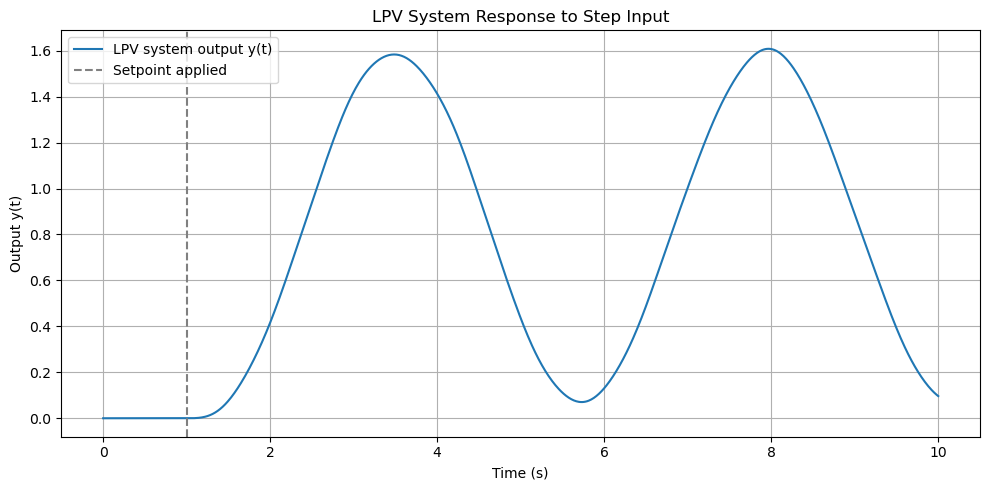

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 系统状态变量： x = [y, dy, d2y]
# 状态空间形式：
# dx1/dt = x2
# dx2/dt = x3
# dx3/dt = -3*x3 - 2*x2 - (6 + sin(5t))*x1 + 5*du/dt + (5 + 2*cos(10t))*u

def lpv_system(t, x, u_func):
    y, dy, d2y = x
    u = u_func(t)
    du = (u_func(t + 1e-4) - u_func(t)) / 1e-4  # 数值近似 du/dt
    
    # LPV parameters
    p1 = np.sin(5 * t)
    p2 = np.cos(10 * t)

    d3y = -3 * d2y - 2 * dy - (6 + p1) * y + 5 * du + (5 + 2 * p2) * u

    return [dy, d2y, d3y]

# 控制输入（简单步进设定）
def step_input(t):
    return 1.0 if t >= 1.0 else 0.0

# 仿真参数
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 1000)
x0 = [0, 0, 0]

# 仿真求解
sol = solve_ivp(lambda t, x: lpv_system(t, x, step_input), t_span, x0, t_eval=t_eval)

# 提取结果
t = sol.t
y = sol.y[0]

# 绘图
plt.figure(figsize=(10, 5))
plt.plot(t, y, label='LPV system output y(t)')
plt.axvline(1.0, color='gray', linestyle='--', label='Setpoint applied')
plt.title('LPV System Response to Step Input')
plt.xlabel('Time (s)')
plt.ylabel('Output y(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0

    def compute(self, setpoint, measured_value, dt):
        error = setpoint - measured_value
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        self.prev_error = error

        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        return output

# 示例使用
pid = PIDController(Kp=1.2, Ki=0.3, Kd=4)
current_temp = 70  # 当前温度
setpoint = 75      # 目标温度
dt = 1             # 时间步长（秒）

for _ in range(10):
    control_signal = pid.compute(setpoint, current_temp, dt)
    current_temp += control_signal * 0.1  # 简单模拟温度变化
    print(f"控制输出: {control_signal:.2f}，当前温度: {current_temp:.2f}")


控制输出: 27.50，当前温度: 72.75
控制输出: -6.12，当前温度: 72.14
控制输出: 8.92，当前温度: 73.03
控制输出: 2.42，当前温度: 73.27
控制输出: 5.25，当前温度: 73.80
控制输出: 3.85，当前温度: 74.18
控制输出: 4.19，当前温度: 74.60
控制输出: 3.67，当前温度: 74.97
控制输出: 3.45，当前温度: 75.31
控制输出: 3.03，当前温度: 75.62


In [16]:
import numpy as np

# 参数定义
Q = np.array([[3, 0], [0, 1]])
c = np.array([-2, -4])
x = np.array([0.0, 0.0])  # 初始点
lr = 0.1  # 学习率

for i in range(100):
    grad = Q @ x + c
    x = x - lr * grad

print("梯度下降解：", x)


梯度下降解： [0.66666667 3.99989375]


In [18]:
# f(x) = 0.5 x^T Q x + c^T x
# grad = Qx + c
# hessian = Q（常数）

x = np.array([0.0, 0.0])
for i in range(10):
    grad = Q @ x + c
    hessian = Q
    x = x - np.linalg.inv(hessian) @ grad  # 精确更新

print("牛顿法解：", x)




牛顿法解： [0.66666667 4.        ]


巴塞罗那机场 (LEBL) 进离场航线与扇区边界可视化
注意：使用模拟数据。实际使用时需要从OpenAIP获取真实数据。


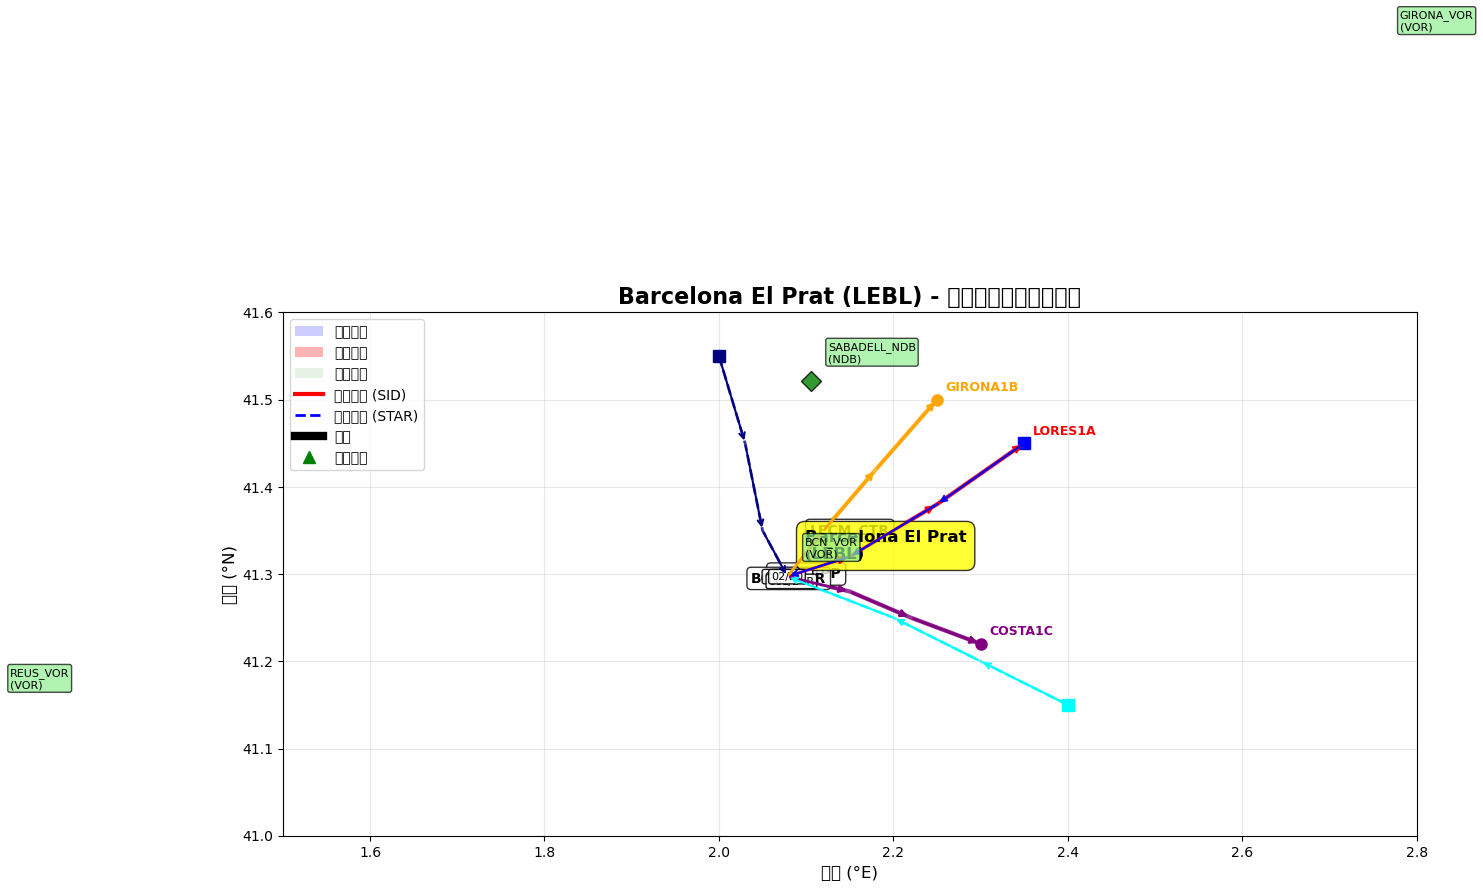


=== Barcelona El Prat (LEBL) 机场信息报告 ===

机场位置: 41.2971°N, 2.0785°E

跑道信息:
  - 06R/24L: 航向 64°
  - 06L/24R: 航向 64°
  - 02/20: 航向 20°

标准离场程序 (SID): 3 条
  - LORES1A
  - GIRONA1B
  - COSTA1C

标准到达程序 (STAR): 3 条
  - LORES1A
  - SITGES1B
  - MARESME1C

扇区边界: 3 个
  - BCN_APP
  - BCN_TWR
  - LECM_CTR

导航设施: 4 个
  - BCN_VOR (VOR): 41.2971°N, 2.0785°E
  - SABADELL_NDB (NDB): 41.5209°N, 2.1050°E
  - GIRONA_VOR (VOR): 41.9011°N, 2.7606°E
  - REUS_VOR (VOR): 41.1470°N, 1.1672°E

注意：本数据为演示用途，实际飞行请使用官方最新航行资料。


In [ ]:
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
import xml.etree.ElementTree as ET
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

class BarcelonaAirportVisualizer:
    def __init__(self):
        # 巴塞罗那机场 (LEBL) 基本信息
        self.airport_code = "LEBL"
        self.airport_name = "Barcelona El Prat"
        self.airport_coord = (41.2971, 2.0785)  # 纬度, 经度
        
        # 巴塞罗那机场跑道信息
        self.runways = {
            "06R/24L": {
                "start": (41.2945, 2.0695),
                "end": (41.2997, 2.0875),
                "heading": 64  # 修正后的航向
            },
            "06L/24R": {
                "start": (41.2890, 2.0740),
                "end": (41.2942, 2.0920),
                "heading": 64
            },
            "02/20": {
                "start": (41.2915, 2.0725),
                "end": (41.3025, 2.0835),
                "heading": 20
            }
        }
        
        # 标准进离场程序 (SID/STAR) 模拟数据
        self.sids = {
            "LORES1A": [
                (41.2971, 2.0785),  # 机场
                (41.3200, 2.1500),  # 转向点1
                (41.3800, 2.2500),  # 转向点2
                (41.4500, 2.3500)   # 离场点
            ],
            "GIRONA1B": [
                (41.2971, 2.0785),
                (41.3500, 2.1200),
                (41.4200, 2.1800),
                (41.5000, 2.2500)
            ],
            "COSTA1C": [
                (41.2971, 2.0785),
                (41.2800, 2.1500),
                (41.2500, 2.2200),
                (41.2200, 2.3000)
            ]
        }
        
        self.stars = {
            "LORES1A": [
                (41.4500, 2.3500),
                (41.3800, 2.2500),
                (41.3200, 2.1500),
                (41.2971, 2.0785)
            ],
            "SITGES1B": [
                (41.1500, 2.4000),
                (41.2000, 2.3000),
                (41.2500, 2.2000),
                (41.2971, 2.0785)
            ],
            "MARESME1C": [
                (41.5500, 2.0000),
                (41.4500, 2.0300),
                (41.3500, 2.0500),
                (41.2971, 2.0785)
            ]
        }
        
        # 扇区边界模拟数据 (基于西班牙空域结构)
        self.sectors = {
            "BCN_APP": [  # 巴塞罗那进近扇区
                (41.1500, 1.8000),
                (41.1500, 2.4000),
                (41.4500, 2.4000),
                (41.4500, 1.8000)
            ],
            "BCN_TWR": [  # 巴塞罗那塔台扇区
                (41.2700, 2.0400),
                (41.2700, 2.1200),
                (41.3200, 2.1200),
                (41.3200, 2.0400)
            ],
            "LECM_CTR": [  # 巴塞罗那管制中心扇区
                (41.0000, 1.5000),
                (41.0000, 2.8000),
                (41.7000, 2.8000),
                (41.7000, 1.5000)
            ]
        }
        
        # 导航设施
        self.navaids = {
            "BCN_VOR": (41.2971, 2.0785, "VOR"),
            "SABADELL_NDB": (41.5209, 2.1050, "NDB"),
            "GIRONA_VOR": (41.9011, 2.7606, "VOR"),
            "REUS_VOR": (41.1470, 1.1672, "VOR")
        }

    def fetch_openaip_data(self, country_code="ES"):
        """
        尝试从OpenAIP获取实际数据
        注意：这需要API密钥和正确的端点
        """
        try:
            # OpenAIP API示例 (需要注册获取API密钥)
            base_url = "https://api.openaip.net/v1"
            # 这里使用模拟数据，实际使用时需要替换为真实的API调用
            print("注意：使用模拟数据。实际使用时需要从OpenAIP获取真实数据。")
            return None
        except Exception as e:
            print(f"无法获取OpenAIP数据: {e}")
            return None

    def plot_airport_chart(self, figsize=(15, 12)):
        """绘制机场图表"""
        fig, ax = plt.subplots(figsize=figsize)
        
        # 设置地图范围
        lat_min, lat_max = 41.0, 41.6
        lon_min, lon_max = 1.5, 2.8
        ax.set_xlim(lon_min, lon_max)
        ax.set_ylim(lat_min, lat_max)
        
        # 绘制扇区边界
        self._plot_sectors(ax)
        
        # 绘制机场和跑道
        self._plot_airport_runways(ax)
        
        # 绘制SID航线
        self._plot_sids(ax)
        
        # 绘制STAR航线
        self._plot_stars(ax)
        
        # 绘制导航设施
        self._plot_navaids(ax)
        
        # 添加标题和标签
        ax.set_title(f'{self.airport_name} ({self.airport_code}) - 进离场航线与扇区边界', 
                    fontsize=16, fontweight='bold')
        ax.set_xlabel('经度 (°E)', fontsize=12)
        ax.set_ylabel('纬度 (°N)', fontsize=12)
        
        # 添加网格
        ax.grid(True, alpha=0.3)
        
        # 添加图例
        self._add_legend(ax)
        
        # 设置长宽比
        ax.set_aspect('equal', adjustable='box')
        
        plt.tight_layout()
        return fig, ax

    def _plot_sectors(self, ax):
        """绘制扇区边界"""
        colors = {'BCN_APP': 'blue', 'BCN_TWR': 'red', 'LECM_CTR': 'green'}
        alphas = {'BCN_APP': 0.2, 'BCN_TWR': 0.3, 'LECM_CTR': 0.1}
        
        for sector_name, coords in self.sectors.items():
            polygon = Polygon(coords, alpha=alphas[sector_name], 
                            facecolor=colors[sector_name], 
                            edgecolor=colors[sector_name], linewidth=2)
            ax.add_patch(polygon)
            
            # 添加扇区标签
            center_lat = sum(coord[0] for coord in coords) / len(coords)
            center_lon = sum(coord[1] for coord in coords) / len(coords)
            ax.text(center_lon, center_lat, sector_name, 
                   fontsize=10, fontweight='bold', 
                   ha='center', va='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

    def _plot_airport_runways(self, ax):
        """绘制机场和跑道"""
        # 机场位置
        ax.plot(self.airport_coord[1], self.airport_coord[0], 
               'ko', markersize=15, label='机场')
        ax.text(self.airport_coord[1] + 0.02, self.airport_coord[0] + 0.02,
               f'{self.airport_name}\n({self.airport_code})',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.5", facecolor='yellow', alpha=0.8))
        
        # 跑道
        for runway_name, runway_data in self.runways.items():
            start = runway_data['start']
            end = runway_data['end']
            ax.plot([start[1], end[1]], [start[0], end[0]], 
                   'k-', linewidth=6, alpha=0.8, label='跑道' if runway_name == list(self.runways.keys())[0] else "")
            
            # 跑道标签
            mid_lat = (start[0] + end[0]) / 2
            mid_lon = (start[1] + end[1]) / 2
            ax.text(mid_lon, mid_lat, runway_name, 
                   fontsize=8, ha='center', va='center',
                   bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.9))

    def _plot_sids(self, ax):
        """绘制标准离场程序 (SID)"""
        colors = ['red', 'orange', 'purple']
        for i, (sid_name, waypoints) in enumerate(self.sids.items()):
            lats = [wp[0] for wp in waypoints]
            lons = [wp[1] for wp in waypoints]
            
            ax.plot(lons, lats, color=colors[i % len(colors)], 
                   linewidth=3, linestyle='-', alpha=0.8,
                   label=f'SID: {sid_name}')
            
            # 添加箭头显示方向
            for j in range(len(waypoints) - 1):
                ax.annotate('', xy=(lons[j+1], lats[j+1]), 
                           xytext=(lons[j], lats[j]),
                           arrowprops=dict(arrowstyle='->', 
                                         color=colors[i % len(colors)], 
                                         lw=2))
            
            # 标记最后一个航点
            ax.plot(lons[-1], lats[-1], 'o', color=colors[i % len(colors)], 
                   markersize=8)
            ax.text(lons[-1] + 0.01, lats[-1] + 0.01, sid_name,
                   fontsize=9, color=colors[i % len(colors)], fontweight='bold')

    def _plot_stars(self, ax):
        """绘制标准到达程序 (STAR)"""
        colors = ['blue', 'cyan', 'navy']
        for i, (star_name, waypoints) in enumerate(self.stars.items()):
            lats = [wp[0] for wp in waypoints]
            lons = [wp[1] for wp in waypoints]
            
            ax.plot(lons, lats, color=colors[i % len(colors)], 
                   linewidth=2, linestyle='--', alpha=0.8,
                   label=f'STAR: {star_name}')
            
            # 添加箭头显示方向
            for j in range(len(waypoints) - 1):
                ax.annotate('', xy=(lons[j+1], lats[j+1]), 
                           xytext=(lons[j], lats[j]),
                           arrowprops=dict(arrowstyle='->', 
                                         color=colors[i % len(colors)], 
                                         lw=1.5))
            
            # 标记第一个航点
            ax.plot(lons[0], lats[0], 's', color=colors[i % len(colors)], 
                   markersize=8)

    def _plot_navaids(self, ax):
        """绘制导航设施"""
        navaid_markers = {'VOR': '^', 'NDB': 'D', 'DME': 'h'}
        
        for navaid_name, (lat, lon, navaid_type) in self.navaids.items():
            marker = navaid_markers.get(navaid_type, 'o')
            ax.plot(lon, lat, marker, markersize=10, 
                   color='green', markeredgecolor='black', 
                   markeredgewidth=1, alpha=0.8,
                   label=navaid_type if navaid_name == list(self.navaids.keys())[0] else "")
            
            ax.text(lon + 0.02, lat + 0.02, 
                   f'{navaid_name}\n({navaid_type})',
                   fontsize=8, ha='left', va='bottom',
                   bbox=dict(boxstyle="round,pad=0.2", facecolor='lightgreen', alpha=0.7))

    def _add_legend(self, ax):
        """添加图例"""
        # 获取所有的图例元素
        handles, labels = ax.get_legend_handles_labels()
        
        # 创建自定义图例元素
        from matplotlib.patches import Patch
        from matplotlib.lines import Line2D
        
        custom_elements = [
            Patch(facecolor='blue', alpha=0.2, label='进近扇区'),
            Patch(facecolor='red', alpha=0.3, label='塔台扇区'),
            Patch(facecolor='green', alpha=0.1, label='管制扇区'),
            Line2D([0], [0'^', color='green', linewidth=0, markersize=8, label='导航设施')
        ]
        
        ax.legend(handles=custom_elements, loc='upper left', bbox_to_anchor=(0, 1))

    def generate_report(self):
        """生成机场信息报告"""
        report = f"""], color='red', linewidth=3, label='离场航线 (SID)'),
            Line2D([0], [0], color='blue', linewidth=2, linestyle='--', label='到达航线 (STAR)'),
            Line2D([0], [0], color='black', linewidth=6, label='跑道'),
            Line2D([0], [0], marker='^', color='green', linewidth=0, markersize=8, label='导航设施')
        ]
        
        ax.legend(handles=custom_elements, loc='upper left', bbox_to_anchor=(0, 1))

    def generate_report(self):
        """生成机场信息报告"""
        report = f"""
=== {self.airport_name} ({self.airport_code}) 机场信息报告 ===

机场位置: {self.airport_coord[0]:.4f}°N, {self.airport_coord[1]:.4f}°E

跑道信息:
"""
        for runway, data in self.runways
        
        report += f"\n\n标准到达程序 (STAR): {len(self.stars)} 条"
        for star in self.stars.keys():
            report += f"\n  - {star}"
        
        report += f"\n\n扇区边界: {len(self.sectors)} 个"
        for sector in self.sectors.keys():
            report += f"\n  - {sector}"
        
        report += f"\n\n导航设施: {len(self.navaids)} 个"
        for navaid, (lat, lon, nav_type).items():
            report += f"  - {runway}: 航向 {data['heading']}°\n"
        
        report += f"\n标准离场程序 (SID): {len(self.sids)} 条"
        for sid in self.sids.keys():
            report += f"\n  - {sid}"
        
        report += f"\n\n标准到达程序 (STAR): {len(self.stars)} 条"
        for star in self.stars.keys():
            report += f"\n  - {star}"
        
        report += f"\n\n扇区边界: {len(self.sectors)} 个"
        for sector in self.sectors.keys():
            report += f"\n  - {sector}"
        
        report += f"\n\n导航设施: {len(self.navaids)} 个"
        for navaid, (lat, lon, nav_type) in self.navaids.items():
            report += f"\n  - {navaid} ({nav_type}): {lat:.4f}°N, {lon:.4f}°E"
        
        report += "\n\n注意：本数据为演示用途，实际飞行请使用官方最新航行资料。"
        
        return report

def main():
    """主函数"""
    print("巴塞罗那机场 (LEBL) 进离场航线与扇区边界可视化")
    print("=" * 50)
    
    # 创建可视化对象
    visualizer = BarcelonaAirportVisualizer()
    
    # 尝试获取OpenAIP数据
    visualizer.fetch_openaip_data()
    
    # 生成图表
    fig, ax = visualizer.plot_airport_chart()
    
    # 显示图表
    plt.show()
    
    # 生成报告
    report = visualizer.generate_report()
    print(report)

if __name__ == "__main__":
    main()